[*********************100%***********************]  1 of 1 completed
Text Metrics:
duration: (30.0, 166.0, 74.71428571428571, 54.0, 53.62435480797348)
total_return: 3.7156141201513386
annualized_return: 1.9538070381425392
volatility: 2.8861638148920017
maximum_drawdown: 0.07120844254888059
win_loss_ratio: 7.0
performance_against_buy_and_hold: 0.39895388825750344


/Users/jmordetsky/Library/Python/3.8/lib/python/site-packages/seaborn/algorithms.py:98: RuntimeWarning:

Mean of empty slice

/Users/jmordetsky/Library/Python/3.8/lib/python/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning:

All-NaN slice encountered



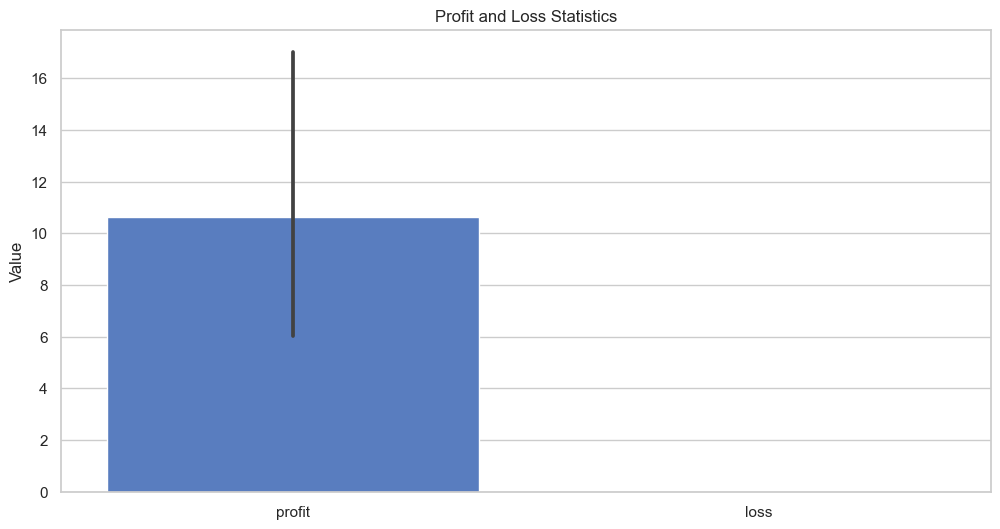

[*********************100%***********************]  1 of 1 completed


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from machine_learning_finance import analyze_trades, generate_probability, attach_markers, \
    calc_durations_with_extremes, plot_full_analysis
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
windows = [300, 600, 900, 1500]

# todo because the inverse strategy is long and long inverse it doesn't render correctl
# we should hack to render as short or render a second time series
file = "../backtests/backtest_inverse_XLE_365_h0.9_l0.1.csv"
symbol = "XLE"
period = 365

ledger = pd.read_csv(file)
metrics = analyze_trades(ledger, symbol, period)

# Set the style for the plots
sns.set(style='whitegrid')

# Display metrics as text
print("Text Metrics:")
for key, value in metrics.items():
    if key not in ['profit_stats', 'loss_stats']:
        print(f"{key}: {value}")

# Create a bar plot for profit and loss stats
profit_stats, loss_stats = metrics['profit_stats'], metrics['loss_stats']
profit_loss_df = pd.DataFrame([profit_stats, loss_stats], columns=['min', 'max', 'mean', 'median', 'std'], index=['profit', 'loss'])

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=profit_loss_df.transpose(), palette='muted')
ax.set_title('Profit and Loss Statistics')
ax.set_ylabel('Value')

# Show the plot
plt.show()

tickerObj = yf.download(tickers=symbol, interval="1d")
df_raw = pd.DataFrame(tickerObj)
df_raw = df_raw.tail(period)


trend, prob_above_trend, prob_below_trend, volatility, model = generate_probability(df_raw)
df_raw = attach_markers(df_raw, trend, prob_above_trend)
df_durations = calc_durations_with_extremes(df_raw)
plot_full_analysis(df_raw, trend, prob_above_trend, prob_below_trend, model, df_durations, ledger)
pd.options.display.max_rows = None

